Example of training and evaluation of a basic neural network.

In [1]:
import sys

sys.path.append('..')   # add gojo path

import torch
import pandas as pd
from torch.utils.data import DataLoader
from sklearn import datasets
from sklearn.model_selection import train_test_split

# GOJO libraries
from gojo import core
from gojo import deepl
from gojo import util
from gojo import plotting

DEVICE = 'mps'

In [2]:
# load test dataset (Wine)
wine_dt = datasets.load_wine()

# create the target variable. Classification problem 0 vs rest
# to see the target names you can use wine_dt['target_names']
y = (wine_dt['target'] == 1).astype(int)  
X = wine_dt['data']

# standarize input data
std_X = util.zscoresScaling(X)

# split Xs and Ys in training and validation
X_train, X_valid, y_train, y_valid = train_test_split(
    std_X, y, train_size=0.8, random_state=1997, shuffle=True, stratify=y)

X_train.shape, X_valid.shape, '%.3f' % y_train.mean(),  '%.3f' % y_valid.mean()

((142, 13), (36, 13), '0.401', '0.389')

In [3]:
# create the dataloaders
train_dl = DataLoader(
    deepl.loading.TorchDataset(X=X_train, y=y_train), 
    batch_size=16, shuffle=True)

valid_dl = DataLoader(
    deepl.loading.TorchDataset(X=X_valid, y=y_valid), 
    batch_size=X_valid.shape[0], shuffle=False)

In [4]:
# create a basic FFN
model = deepl.ffn.createSimpleFFNModel(
    in_feats=X_valid.shape[1],
    out_feats=1,
    layer_dims=[20],
    layer_activation=torch.nn.ELU(),
    output_activation=torch.nn.Sigmoid()
)
model

Sequential(
  (LinearLayer 0): Linear(in_features=13, out_features=20, bias=True)
  (Activation 0): ELU(alpha=1.0)
  (LinearLayer 1): Linear(in_features=20, out_features=1, bias=True)
  (Activation 1): Sigmoid()
)

In [5]:
output = deepl.fitNeuralNetwork(
    deepl.iterSupervisedEpoch,
    model=model,
    train_dl=train_dl,
    valid_dl=valid_dl,
    n_epochs=50,
    loss_fn=torch.nn.BCELoss(),
    optimizer_class=torch.optim.Adam,
    optimizer_params={'lr': 0.001},
    device=DEVICE,
    metrics=core.getDefaultMetrics('binary_classification', bin_threshold=0.5)
)

Training model...: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.60it/s]


In [6]:
output.keys()

dict_keys(['train', 'valid'])

In [7]:
train_info = output['train']
valid_info = output['valid']

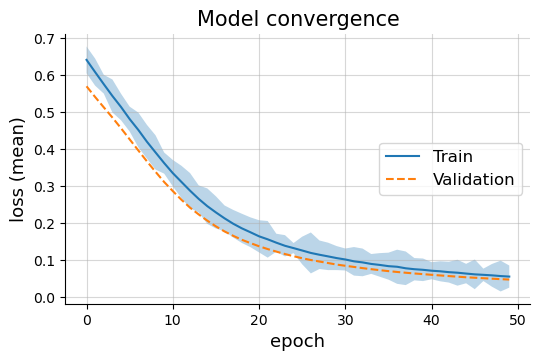

In [8]:
plotting.linePlot(
    train_info, valid_info,
    x='epoch', y='loss (mean)', err='loss (std)',
    legend_labels=['Train', 'Validation'],
    title='Model convergence',
    ls=['solid', 'dashed'],
    style='default', legend_pos='center right'
)

In [9]:
# model saving/loading
path_to_saved_model = util.io.serialize(model, 'test_gzip.pkl', backend='pickle_gzip')
loaded_model = util.io.load(path_to_saved_model)

In [10]:
# make model predictions
loaded_model = loaded_model.eval()
X, y = next(iter(valid_dl))
y_hat = loaded_model(X.to(device=DEVICE))
y_hat = y_hat.detach().cpu().numpy()
y = y.cpu().numpy()
((y_hat.reshape(-1) > 0.5).astype(int) == y.reshape(-1)).mean()

1.0